# Water Model Calibration

In [2]:
import wntr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import scipy as sp

(<matplotlib.collections.PathCollection at 0x226889faa58>,
 <matplotlib.collections.LineCollection at 0x226889faf28>)

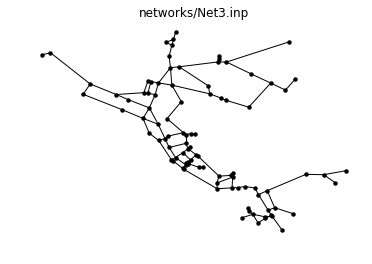

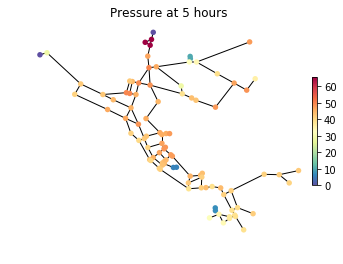

In [3]:
# Create a water network model
inp_file = 'networks/Net3.inp'
wn = wntr.network.WaterNetworkModel(inp_file)

# Graph the network
wntr.graphics.plot_network(wn, title=wn.name)

# Simulate hydraulics
sim = wntr.sim.EpanetSimulator(wn)
results = sim.run_sim()

# Plot results on the network
pressure_at_5hr = results.node['pressure'].loc[5*3600, :]
wntr.graphics.plot_network(wn, node_attribute=pressure_at_5hr, node_size=30, 
                        title='Pressure at 5 hours')

In [4]:
results.node.keys()

dict_keys(['demand', 'head', 'pressure', 'quality'])

In [5]:
results.link.keys()

dict_keys(['linkquality', 'flowrate', 'headloss', 'velocity', 'status', 'setting', 'frictionfact', 'rxnrate'])

In [6]:
results.link["flowrate"]

name,20,40,50,60,101,103,105,107,109,111,...,317,319,321,323,325,329,330,333,10,335
0,-0.141719,-0.029042,0.020770,0.830133,6.176596e-09,0.010603,-0.026661,0.002038,-0.000658,-0.020221,...,0.007019,-0.000032,0.476306,-0.005008,0.009100,0.830133,0.0,-2.890559e-08,0.000000,0.830133
900,-0.140299,-0.028087,0.018739,0.829788,6.040704e-09,0.010637,-0.026695,0.002060,-0.000624,-0.020187,...,0.007066,0.000174,0.477233,-0.003474,0.009115,0.829788,0.0,-2.961881e-08,0.000000,0.829788
1800,-0.138921,-0.027249,0.016868,0.829444,6.040704e-09,0.010670,-0.026728,0.002080,-0.000591,-0.020154,...,0.007101,0.000412,0.478123,-0.002102,0.009130,0.829444,0.0,-2.976975e-08,0.000000,0.829444
2700,-0.137581,-0.026514,0.015136,0.829101,5.903469e-09,0.010701,-0.026760,0.002101,-0.000559,-0.020122,...,0.007127,0.000665,0.478980,-0.000859,0.009145,0.829101,0.0,-2.980169e-08,0.000000,0.829101
3600,-0.191883,-0.063253,0.019999,0.824093,2.167265e-01,0.116471,0.077007,0.026059,0.100168,0.071846,...,0.007516,0.004375,0.488116,0.010095,0.013403,0.824093,0.0,-2.981023e-08,0.216727,0.824093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
601200,-0.059172,0.045216,0.029522,0.833460,6.308641e-09,0.007704,-0.027717,-0.000808,-0.006330,-0.030711,...,0.007120,0.001835,0.444611,-0.002138,0.006757,0.833460,0.0,-2.981025e-08,0.000000,0.833460
602100,-0.055806,0.043263,0.028172,0.833398,6.175332e-09,0.007798,-0.027811,-0.000752,-0.006236,-0.030616,...,0.007140,0.002021,0.447437,-0.001160,0.006815,0.833398,0.0,-2.981027e-08,0.000000,0.833398
603000,-0.052553,0.041350,0.026891,0.833338,6.175332e-09,0.007890,-0.027903,-0.000697,-0.006144,-0.030524,...,0.007155,0.002212,0.450166,-0.000243,0.006870,0.833338,0.0,-2.981027e-08,0.000000,0.833338
603900,-0.049411,0.039483,0.025676,0.833280,6.307505e-09,0.007979,-0.027992,-0.000644,-0.006055,-0.030435,...,0.007168,0.002406,0.452802,0.000616,0.006927,0.833280,0.0,-3.850155e-08,0.000000,0.833280


In [7]:
flowrates = results.link["flowrate"].transpose()
flowrates.columns = [float(seconds)/3600.0 for seconds in flowrates.columns]

In [ ]:
flowrates.plot(kind="bar",stacked="true")

In [ ]:
def extractDataFrame(wn,objType="Pipe"):
    objsDict = {}
    try:
        objIter = wn.pipes()
        if objType == "Junction":
            objIter = wn.junctions()
        for obj in objIter:
            obj = obj[1]
            objDict = obj.todict()
            for k,v in objDict.items():
                if k in objsDict.keys():
                    objsDict[k].append(v)
                else:
                    objsDict[k] = [v]
        objsDF = pd.DataFrame(objsDict)
        return objsDF
    except:
        return objsDict

In [ ]:
pipesDF = extractDataFrame(wn)
pipesDF

In [ ]:
junctionsDF = extractDataFrame(wn,"Junction")
junctionsDF

In [ ]:
class Sensor():
    def __init__(self,junctionName):
        self.junctionName = junctionName
        self.timeSeries = []

In [ ]:
class Calibrator():
    def __init__(self,pipeName,distribution):
        self.pipeName = pipeName
        self.prior = distribution # type of distribution
        self.values = []

In [ ]:
c1 = Calibrator(1,stats.norm(110,40))
c2 = Calibrator(2,stats.norm(130,20))

In [ ]:
"""
This function generates the random numbers for the parameters being tested
"""
def π(listOfCalibrators):
    estimatesDict = {}
    for calibrator in listOfCalibrators:
        rv = calibrator.prior.rvs()
        estimatesDict[calibrator] = rv
    return estimatesDict     

In [ ]:
π([c1,c2])

In [ ]:
"""
This function calculates the probability that the parameters are 
pulled from their distribution
"""
def π_Prior(estimatesDict):
    p = 1.0
    for calibrator,parameterValue in estimatesDict.items():
        pi = calibrator.prior.pdf(parameterValue)
        p *= pi
    return p

In [ ]:
π_Prior(π([c1,c2]))

In [ ]:
π_Prior({c1:1,c2:2})

In [ ]:
"""
This function loops through a set of observations and calculates the
log-liklihood of each, summed
"""
def π_Log_Likelihood():
    return None

In [ ]:
def MCMC():
    return None

In [ ]:
def GA():
    return None

In [ ]:
>>> junction = wn.get_node('121')
>>> junction.elevation = 5
>>> pipe = wn.get_link('122')
>>> pipe.diameter = pipe.diameter*0.5
>>> tank = wn.get_node('1')
>>> tank.diameter = tank.diameter*1.1

In [ ]:
pipe

In [ ]:
wn.links()

In [ ]:
def waterNetworkToDataFrame():
    dfDict = {}
    
    return 0

In [ ]:
sim = wntr.sim.EpanetSimulator(wn)

In [ ]:
results = sim.run_sim()

In [ ]:
pressure_at_5hr = results.node['pressure'].loc[5*3600, :]
wntr.graphics.plot_network(wn, node_attribute=pressure_at_5hr, node_size=30, 
                        title='Pressure at 5 hours')

In [ ]:
class WNLink():
    def __init__(self,pipeToCopy):
        self.basePipe = pipeToCopy
        self.dict = pipeToCopy.todict()
        self.network = pipeToCopy.wn
    def updateNetwork(network):
        toUpdate = network.get_link(self.dict["name"])
        toUpdate.diameter = 0.5
    def __repr__(self):
        return "hello world"

In [ ]:
b = WNLink(a)

In [ ]:
b.dict

In [ ]:
b

# Let's do this

For simplicity, we are treating the only system states as flow rate, and the only parameters as pipe roughness

## Inputs

In [ ]:
class Parameter():
    def __init__(self,pipeName,value,distribution=None,isFixed=True):
        self.pipeName = pipeName
        self.value = value
        self.distribution = distribution
        self.isFixed = isFixed
        
    def generateValue(self):
        return 0
    
    def probabilityOfValue(self):
        return 0

In [ ]:
class Model():
    def __init__(self,wn,listOfParameters):
        self.wn = wn
        self.listOfParameters = listOfParameters

### Fixed Inputs

### Distributions of Priors

### Trusted System States and their Distributions (Uncertainty) for Calibration

## Methods

### $\pi$- Generates the random values for the parameters being tested

### $\pi_{prior}$- Calculates the probability that a set of parameter 'states' are pulled from their distributions

### $\pi_{log liklihood}$- The sum of the log liklihood of each resulting system state matching the trusted system state

## Black Box Model Workflow

1. Set the parameters for the model, both fixed and pulling from distributions
2. Run the model with the selected parameters
3. Compare model results to the "sensor" feeds
4. Calculate the acceptance ratio

For parameter in wn.parameters:
    parameterProbability = 1.0
    if parameter.isFixed:
        wn.setParameter(parameter.value)
    else:
        value,probability = parameter.generateProposal()
        wn.setParameter(value)
        parameterProbability *= probability
results = wn.runSimulation()
resultsProbability = 1.0
for calibrator in calibrators:
    comparableResult = extractResult(results,calibrator)
    resultProbability = calibrator.distribution.rvs(comparableResult,calibrator.value,calibrator.std)
    resultsProbability *= resultProbability
calculateAlpha(resultsProbability,parameterProbability)
   